# Bayesian UQ-SINDy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

import pysindy as ps

In [2]:
# set seed for reproducibility
np.random.seed(987)

### Harmonic Oscillator

In [3]:
# set up a class that defines a harmonic oscillator
class HarmonicOscillator:
    def __init__(self, zeta=0.1, omega0=2*np.pi):
        # internalise the model parameters.
        self.zeta = zeta
        self.omega0 = omega0

    def y_next(self, y, dt):
        # Lotka-Volterra Model model, see e.g. https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations.}
        return np.array([dt*y[1] + y[0],
                         dt*(-2*self.zeta*self.omega0*y[1] - self.omega0**2*y[0]) + y[1]])

    def solve(self, y0, dt, n_steps):
        y = np.zeros((n_steps+1, y0.shape[0]))
        y[0,:] = y0
        for i in range(n_steps):
            y[i+1,:] = self.y_next(y[i,:], dt)
        return y

In [4]:
# set some hyperparameters.
y0 = np.array([1,0])
dt = 0.01
n_steps = 500

# initialise the model and solve.
my_model = HarmonicOscillator()
y = my_model.solve(y0, dt, n_steps)

In [17]:
# the noise level.
noise = 1e-2

# extract the timesteps and perturb the solution with noise.
t = np.linspace(0, dt*n_steps, y.shape[0])
x = y[:,0] + np.random.normal(scale=noise, size=n_steps+1)
v = y[:,1] + np.random.normal(scale=noise, size=n_steps+1)

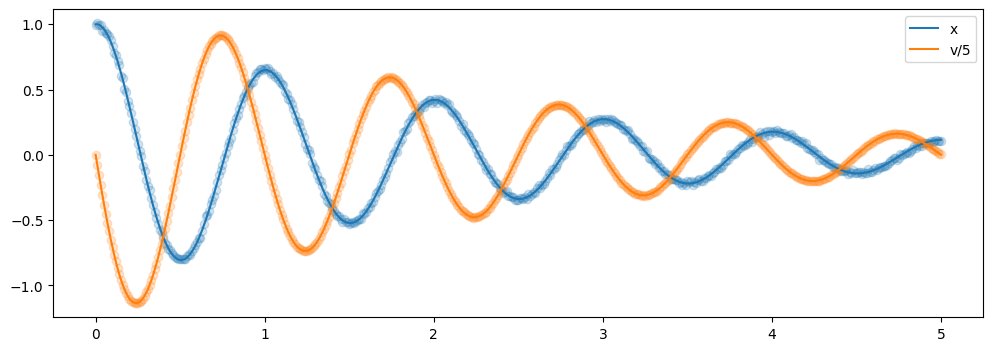

In [18]:
# plot the solution.
plt.figure(figsize=(12,4))
plt.plot(t, y[:,0], label = "x")
plt.scatter(t, x, alpha=0.2)
plt.plot(t, y[:,1]/5, label="v/5")
plt.scatter(t, v/5, alpha=0.2)
plt.legend()
plt.show()

### Bayesian UQ-SINDy

Here we recover the governing equations using UQ-SINDy. For more details on the theory of the method, see Hirsh, S. M., Barajas-Solano, D. A., & Kutz, J. N. (2021). *Sparsifying Priors for Bayesian Uncertainty Quantification in Model Discovery* (arXiv:2107.02107). arXiv. http://arxiv.org/abs/2107.02107

The underlying code used to find the posterior distribution of model parameters is `numpyro.infer.MCMC` using the `numpyro.infer.NUTS` kernel. Note that all keyword arguments passed to `pysindy.optimizers.SBR` are sent forward to the [MCMC sampler](https://num.pyro.ai/en/stable/mcmc.html).

In [19]:
# set sampler hyperparameters
sampling_seed = 123

if __name__ == "testing":
    num_warmup = 10
    num_samples = 100
    num_chains = 1
else:
    num_warmup = 2000
    num_samples = 10000
    num_chains = 2

In [20]:
# initialise the Sparse bayesian Regression optimizer.
optimizer = ps.optimizers.SBR(num_warmup=num_warmup,
                              num_samples=num_samples,
                              mcmc_kwargs={"seed": sampling_seed,
                                           "num_chains": num_chains})

#optimizer = ps.optimizers.SSR()

# use the standard polynomial features.
feature_library = ps.feature_library.polynomial_library.PolynomialLibrary(include_bias=False)

# initialise SINDy and fit to the data
sindy = ps.SINDy(optimizer, feature_library, feature_names=['x', 'v'], discrete_time=True)
sindy.fit(np.c_[x, v], t=dt)

sample: 100%|█| 12000/12000 [00:17<00:00, 682.64it/s, 127 steps of size 2.11e-02
sample: 100%|█| 12000/12000 [00:15<00:00, 772.17it/s, 127 steps of size 2.85e-02


SINDy(differentiation_method=FiniteDifference(axis=-2), discrete_time=True,
      feature_library=PolynomialLibrary(include_bias=False),
      feature_names=['x', 'v'],
      optimizer=SBR(mcmc_kwargs={'num_chains': 2, 'seed': 123},
                    num_samples=10000, num_warmup=2000))

In [21]:
sindy.equations()

['0.999 x[k] + 0.010 v[k]', '-0.395 x[k] + 0.987 v[k] + 0.001 x[k]^2']

In [22]:
# set up a new differential equation that uses the Bayesian SINDy predictions.
def surrogate_y_next(y, dt):
    _y = y[np.newaxis,:]
    return sindy.predict(x=_y)

y_sur = np.zeros((n_steps+1, y0.shape[0]))
y_sur[0,:] = y0
for i in range(n_steps):
    y_sur[i+1,:] = surrogate_y_next(y_sur[i,:], dt)

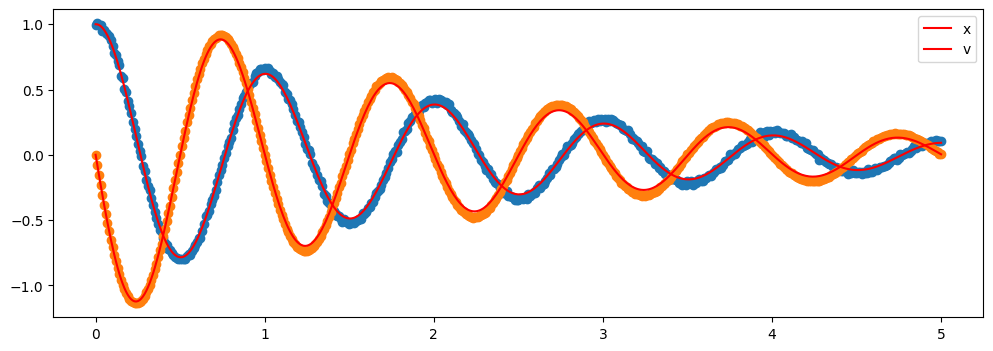

In [23]:
# plot the surrogate solution.
plt.figure(figsize=(12,4))

plt.plot(t, y_sur[:,0], label = "x", c='r')
plt.scatter(t, x, zorder=0)

plt.plot(t, y_sur[:,1]/5, label="v", c='r')
plt.scatter(t, v/5, zorder=0)

plt.legend()
plt.show()

### Get MCMC diagnostics

We can inspect the posterior samples in more detail using `arviz`. Note that this is not included as a dependency of `pysindy` and must be installed separately.

In [24]:
# import arviz.
import arviz as az

In [25]:
# convert the numpyro samples to an arviz.InferenceData object.
samples = az.from_numpyro(sindy.optimizer.mcmc_)

# have a look at the summray.
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.999,0.002,0.995,1.003,0.000,0.000,6737.0,2133.0,1.0
"beta[0, 1]",0.010,0.000,0.009,0.011,0.000,0.000,16154.0,10423.0,1.0
"beta[0, 2]",0.000,0.002,-0.005,0.005,0.000,0.000,8979.0,10290.0,1.0
"beta[0, 3]",0.000,0.001,-0.001,0.001,0.000,0.000,3624.0,1614.0,1.0
"beta[0, 4]",-0.000,0.000,-0.000,0.000,0.000,0.000,16591.0,14769.0,1.0
"beta[1, 0]",-0.395,0.002,-0.398,-0.391,0.000,0.000,12742.0,9193.0,1.0
"beta[1, 1]",0.987,0.000,0.987,0.988,0.000,0.000,5893.0,10413.0,1.0
"beta[1, 2]",0.001,0.002,-0.004,0.006,0.000,0.000,3853.0,8538.0,1.0
"beta[1, 3]",0.000,0.001,-0.001,0.002,0.000,0.000,13570.0,10798.0,1.0
"beta[1, 4]",0.000,0.000,-0.000,0.000,0.000,0.000,18925.0,13341.0,1.0


[]

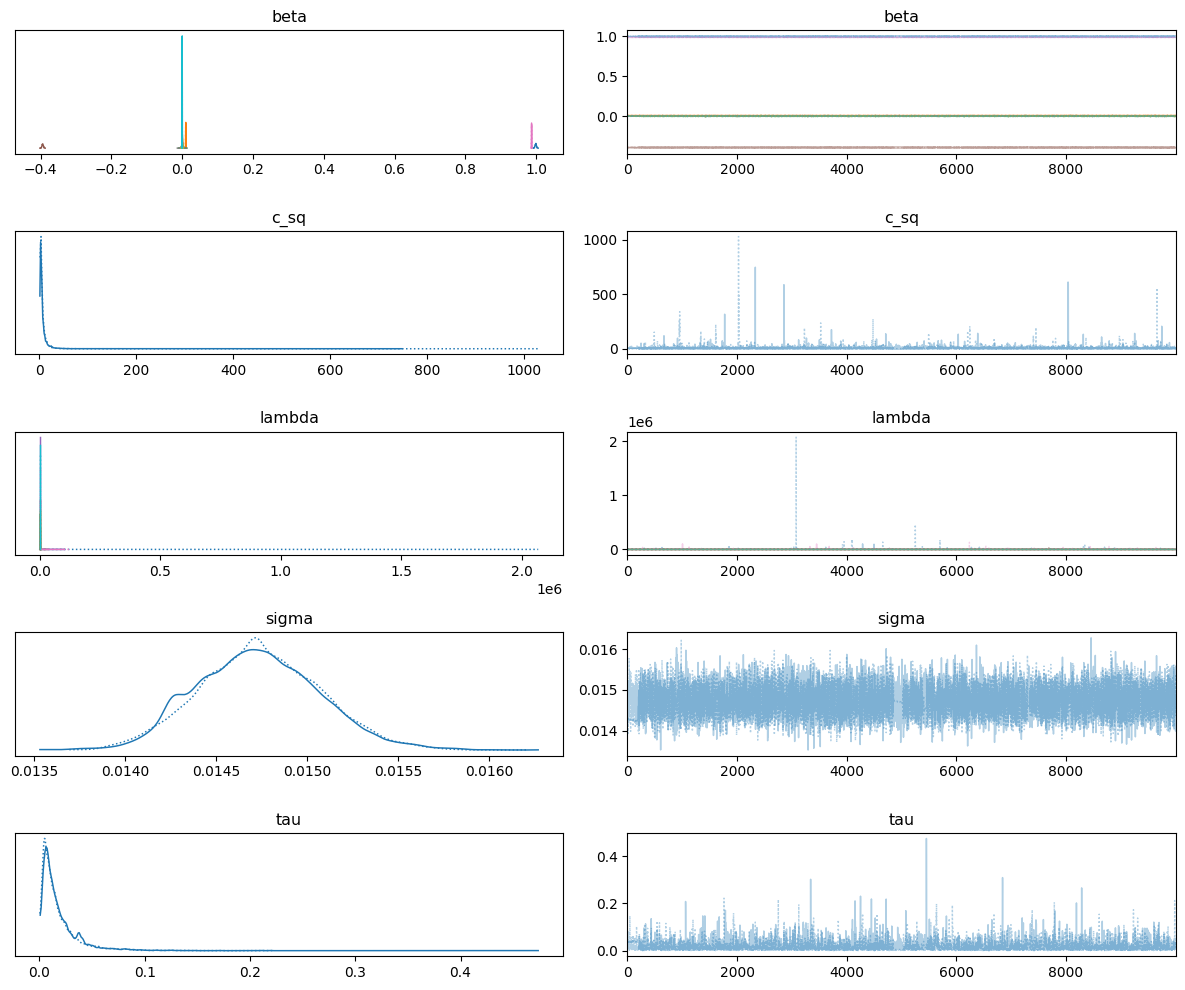

In [26]:
# plot the traces.
az.plot_trace(samples, divergences=False)
plt.tight_layout()
plt.plot()